In [1]:
import findspark
findspark.init()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pyspark import SparkContext
from pyspark.conf import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql import types 
from pyspark.sql.functions import mean, stddev, col, log, datediff
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import when
from pyspark.sql.types import DateType

from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [3]:
sc = SparkContext()
spark = SparkSession(sc)

In [4]:
df = spark.read.csv("../../Data/2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

In [5]:
df.show(5)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+----------+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+

In [6]:
# Drop columns in list
df = df.drop(*['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS'])
df.show(5)

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+----------+---------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+-----------------+
| No|MLSID|       s

In [7]:
# Sum two columns
df = df.withColumn('TSQFT', (df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND']))
# Divide two columns
df = df.withColumn('PRICEPERTSQFT', (df['LISTPRICE'] / df['TSQFT']))

In [8]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)
# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Correlation of ACRES vs SalesClosePrice
print('Correlation of ACRES vs SalesClosePrice:', str(df.corr('ACRES', 'SalesClosePrice')))
# Correlation of ACRES vs SalesClosePrice
print('Correlation of FOUNDATIONSIZE vs SalesClosePrice:', str(df.corr('FOUNDATIONSIZE', 'SalesClosePrice')))
# Correlation of YARD_SIZE vs SalesClosePrice
print('Correlation of ACRES vs SalesClosePrice:', str(df.corr('YARD_SIZE', 'SalesClosePrice')))

Correlation of ACRES vs SalesClosePrice: 0.22060612588935327
Correlation of FOUNDATIONSIZE vs SalesClosePrice: 0.6152231695664401
Correlation of ACRES vs SalesClosePrice: 0.20714585430854263


In [9]:
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.3333333333333333|       4|         3|
|               2.0|       2|         1|
|               1.0|       2|         2|
|               1.5|       3|         2|
+------------------+--------+----------+
only showing top 5 rows



### Tạo ra các thành phần từ Time Feature

In [10]:
# Convert to date type
func = udf(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'), DateType())
df = df.withColumn('LISTDATE_new', func(col('LISTDATE')))
# Get the ate of week
df = df.withColumn('List_Day_of_week', dayofweek('LISTDATE_new'))
# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

In [11]:
sample_df[['LISTDATE', 'LISTDATE_new', 'List_Day_of_week']].head(5)

,LISTDATE,LISTDATE_new,List_Day_of_week
0,8/25/2017 0:00,2017-08-25,6
1,11/5/2017 0:00,2017-11-05,1
2,5/19/2017 0:00,2017-05-19,6
3,3/12/2017 0:00,2017-03-12,1
4,9/10/2017 0:00,2017-09-10,1


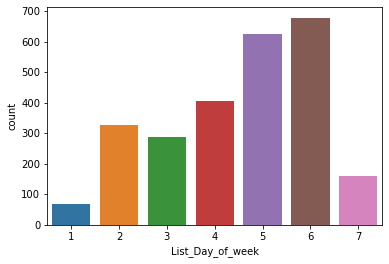

In [12]:
# Plot count plot of day of week
ax = sns.countplot(x="List_Day_of_week", data=sample_df)
plt.show()

In [13]:
# Create a new column with year of number
df = df.withColumn('LIST_YEAR', year('LISTDATE_new'))
# Create a new column with month of number
df = df.withColumn('LIST_MONTH', month('LISTDATE_new'))
# Create a new column of the day number within the month
df = df.withColumn('LIST_DAYOFMONTH', dayofmonth('LISTDATE_new'))
# Create a new column of the week number within the year
df = df.withColumn('LIST_WEEKOFYEAR', weekofyear('LISTDATE_new'))

df[['LISTDATE_new', 'LIST_YEAR', 'LIST_MONTH', 'LIST_DAYOFMONTH', 'LIST_WEEKOFYEAR']].show(3)

+------------+---------+----------+---------------+---------------+
|LISTDATE_new|LIST_YEAR|LIST_MONTH|LIST_DAYOFMONTH|LIST_WEEKOFYEAR|
+------------+---------+----------+---------------+---------------+
|  2017-07-15|     2017|         7|             15|             28|
|  2017-10-09|     2017|        10|              9|             41|
|  2017-06-26|     2017|         6|             26|             26|
+------------+---------+----------+---------------+---------------+
only showing top 3 rows



In [14]:
df = df.withColumn('OFFMARKETDATE_new', func(col('OFFMARKETDATE')))
df = df.withColumn('DAYSONMARKET',datediff('OFFMARKETDATE_new','LISTDATE_new'))
df[['DAYSONMARKET','OFFMARKETDATE_new','LISTDATE_new']].show(5)

+------------+-----------------+------------+
|DAYSONMARKET|OFFMARKETDATE_new|LISTDATE_new|
+------------+-----------------+------------+
|          15|       2017-07-30|  2017-07-15|
|           4|       2017-10-13|  2017-10-09|
|          28|       2017-07-24|  2017-06-26|
|          19|       2017-09-13|  2017-08-25|
|          21|       2017-10-03|  2017-09-12|
+------------+-----------------+------------+
only showing top 5 rows



## Trích xuất tính năng (Extracting Feature)

### Trích xuất text thành feature mới

In [15]:
# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')
# Conditional value assignment
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                           .when(has_detached_garage, 0)
                                           .otherwise(None)))
# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(5, truncate=100)

+--------------------------------------------------------------+-------------------+
|                                             GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------------------+-------------------+
|                                               Attached Garage|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                               Attached Garage|                  1|
|Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
+--------------------------------------------------------------+-------------------+
only showing top 5 rows



### Cắt chuỗi(spliting) thành feature mới

In [16]:
# Split the column on commas into a list
split_col = split(df['ROOF'], ',')
# Put the first value of the list into a new column
df = df.withColumn('Roof_Material', split_col.getItem(0))
# Inspect the values
df[['ROOF', 'Roof_Material']].show(n=5, truncate=100)

+----------------------------------------------+----------------+
|                                          ROOF|   Roof_Material|
+----------------------------------------------+----------------+
|                                          null|            null|
|Asphalt Shingles, Pitched, Age 8 Years or Less|Asphalt Shingles|
|                                          null|            null|
|Asphalt Shingles, Pitched, Age 8 Years or Less|Asphalt Shingles|
|            Asphalt Shingles, Age Over 8 Years|Asphalt Shingles|
+----------------------------------------------+----------------+
only showing top 5 rows



### Tạo nhiều thuộc tính mới (exploding) cho record

In [17]:
# Convert string to list-like array
df = df.withColumn('roof_list', split(df['ROOF'], ', '))
df[["No", "roof_list"]].show(4, truncate=50)

+---+------------------------------------------------+
| No|                                       roof_list|
+---+------------------------------------------------+
|  1|                                            null|
|  2|[Asphalt Shingles, Pitched, Age 8 Years or Less]|
|  3|                                            null|
|  4|[Asphalt Shingles, Pitched, Age 8 Years or Less]|
+---+------------------------------------------------+
only showing top 4 rows



In [18]:
# Explode the values into new records
roof_df = df.withColumn('ex_roof_list', explode(df['roof_list']))
# Inspect the values
roof_df[['No', 'ex_roof_list']].show(n=5, truncate=50)

+---+-------------------+
| No|       ex_roof_list|
+---+-------------------+
|  2|   Asphalt Shingles|
|  2|            Pitched|
|  2|Age 8 Years or Less|
|  4|   Asphalt Shingles|
|  4|            Pitched|
+---+-------------------+
only showing top 5 rows



### Pivot

In [19]:
# Create a dummy column of constant value
roof_df = roof_df.withColumn('constant_val', lit(1))
roof_df[['No', 'ex_roof_list', 'constant_val']].show(5)

+---+-------------------+------------+
| No|       ex_roof_list|constant_val|
+---+-------------------+------------+
|  2|   Asphalt Shingles|           1|
|  2|            Pitched|           1|
|  2|Age 8 Years or Less|           1|
|  4|   Asphalt Shingles|           1|
|  4|            Pitched|           1|
+---+-------------------+------------+
only showing top 5 rows



In [20]:
# Pivot the values into booleans columns
roof_piv_df = roof_df.groupBy('No').pivot('ex_roof_list').agg(coalesce(first('constant_val')))
roof_piv_df.orderBy('No').show(5)

+---+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
| No|Age 8 Years or Less|Age Over 8 Years|Asphalt Shingles|Flat|Metal|Other|Pitched|Rubber|Shakes|Slate|Tar/Gravel|Tile|Unspecified Shingle|Wood Shingles|
+---+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
|  2|                  1|            null|               1|null| null| null|      1|  null|  null| null|      null|null|               null|         null|
|  4|                  1|            null|               1|null| null| null|      1|  null|  null| null|      null|null|               null|         null|
|  5|               null|               1|               1|null| null| null|   null|  null|  null| null|      null|null|               null|         null|
|  6|                  1|            null|               1|null| null|

### Join

In [21]:
# Join the dataframes together and fill null
joined_data = df.join(roof_piv_df, on='No', how='left')
# Columns to zero fill
zfill_cols = roof_piv_df.columns
# Zero fill the pivoted values
zfilled_df = joined_data.fillna(0, subset=zfill_cols)

### Binarizing

In [22]:
# Cast the data type to double
df = df.withColumn('YARD_SIZE', df['YARD_SIZE'].cast('double'))
# Create binarizing transformer
bin = Binarizer(threshold=500.0, inputCol='YARD_SIZE', outputCol='YARD_SIZE_B')
# Apply the transformer
df = bin.transform(df)
# Inspect the results
df[['YARD_SIZE', 'YARD_SIZE_B']].show(6)

+------------------+-----------+
|         YARD_SIZE|YARD_SIZE_B|
+------------------+-----------+
|           54776.8|        1.0|
|           12795.2|        1.0|
|          34704.32|        1.0|
|39987.399999999994|        1.0|
|           -1026.0|        0.0|
|           6340.32|        1.0|
+------------------+-----------+
only showing top 6 rows



### Bucketing

In [23]:
# Define how to split data
splits = [0, 1, 2, 3, 4, float('Inf')]
# Create bucketing transformer
buck = Bucketizer(splits=splits, inputCol='BATHSTOTAL', outputCol='baths')
# Apply transformer
df = buck.transform(df)
# Inspect the results
df[['BATHSTOTAL', 'baths']].show(5)

+----------+-----+
|BATHSTOTAL|baths|
+----------+-----+
|         2|  2.0|
|         3|  3.0|
|         1|  1.0|
|         2|  2.0|
|         2|  2.0|
+----------+-----+
only showing top 5 rows



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


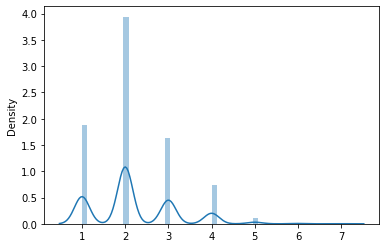

In [24]:
sns.distplot(df[['BATHSTOTAL']].toPandas())
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


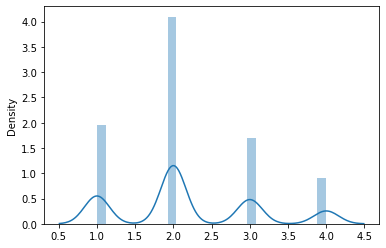

In [25]:
sns.distplot(df[['baths']].toPandas())
plt.show()

### OneHotEncoding

In [26]:
# Create indexer transformer
stringIndexer = StringIndexer(inputCol='City', outputCol='City_Index')

In [27]:
# Fit transformer
model = stringIndexer.fit(df)
# Apply transformer
indexed = model.transform(df)

In [ ]:
indexed[['City', 'City_Index']].show(5)